# Fase 3: Modelagem (CRISP-DM)

## Objetivo da Fase

O objetivo desta etapa é desenvolver, comparar e otimizar modelos capazes de detectar transações fraudulentas com o máximo desempenho possível, respeitando as características específicas do problema, como **extremo desbalanceamento**, **custo assimétrico de erros** e **alta variabilidade temporal**.  

Nesta fase, o foco é construir um processo de modelagem **reprodutível**, **estatisticamente sólido** e **livre de vazamento de dados**, permitindo comparar algoritmos de forma justa.

---

## Justificativa

Modelos de fraude exigem uma abordagem especial por três motivos:

1. **Desbalanceamento extremo**  
   Apenas ~0,17% das transações são fraude. Se o modelo aprender sem cuidados, ele tende a prever sempre “não fraude”.  
   Por isso, técnicas como **SMOTE dentro da Cross-Validation** são essenciais.

2. **Sensibilidade ao custo dos erros**  
   - Falsos Negativos (fraudes não detectadas) têm impacto elevado.  
   - Falsos Positivos geram incômodo e custo operacional.  
   A solução precisa equilibrar ambos usando:
   - métricas corretas (AUC-PR, recall, precision),
   - **threshold tuning** com objetivo definido (ex.: F1, Fβ, precisão mínima).

3. **Risco alto de data leakage**  
   Qualquer pré-processamento feito antes do split — ou fora do pipeline — pode introduzir viés e gerar **métricas irreais**.  
   Por isso, toda a preparação (imputação, escala, codificação, SMOTE) acontece **dentro de um Pipeline sklearn/imbalanced-learn**, garantindo isolamento entre folds.

Com base nesses pontos, esta fase aplica uma metodologia alinhada às melhores práticas de machine learning moderno para problemas críticos.

---

## Etapas da Modelagem

### 1. **Carregamento do dataset bruto**
A modelagem parte do mesmo dataset utilizado no EDA e na preparação, garantindo consistência entre fases.  
Nenhum pré-processamento manual é aplicado aqui.

---

### 2. **Carregamento das listas oficiais de features**
As listas `numeric_cols` e `categorical_cols`, definidas no Notebook 2, são readquiridas através de um arquivo de metadados (`preprocessing_metadata.json`).  
Caso não existam, são recalculadas de forma reprodutível.

Isso garante que a modelagem use **exatamente as mesmas features decididas na fase de preparação**.

---

### 3. **Benchmark inicial com validação cruzada estratificada**
Um experimento comparando múltiplos algoritmos é realizado:

- Regressão Logística  
- Random Forest  
- XGBoost  
- LightGBM  
- CatBoost  

A comparação segue o mesmo esquema para todos os modelos:

- `StratifiedKFold`
- `SMOTE` **dentro dos folds**
- Pipeline: `preprocessor → SMOTE → modelo`
- Métrica principal: **AUC-PR (Average Precision)**, mais adequada para dados desbalanceados

Dessa forma, nenhuma técnica recebe vantagem indevida, e os resultados são comparáveis.

---

### 4. **Seleção do modelo final para tuning**
Após o benchmark, o modelo com melhor AUC-PR médio é escolhido como candidato principal para otimização (frequentemente XGBoost, LightGBM ou CatBoost).

Essa seleção é **baseada em evidências estatísticas**, não em preferências pessoais ou comportamento em um único split.

---

### 5. **Otimização de hiperparâmetros com Randomized Search**
Utiliza-se `RandomizedSearchCV` com:

- pipeline completo (preprocessador + SMOTE + modelo)
- espaço de busca bem definido
- múltiplas combinações avaliadas
- validação cruzada interna

Essa etapa produz um **pipeline completo otimizado**, já preparado para ser salvo como artefato.

---

### 6. **Tuning do Threshold com Cross-Validation (“Nested Threshold CV”)**
Como modelos probabilísticos retornam scores contínuos, o limiar de decisão padrão (0.5) raramente é adequado.

Aqui o threshold é ajustado com base em:
- **Fβ-score** (com foco controlável entre recall e precision), ou  
- **precision mínima desejada**, ou  
- **maximização da AUC-PR**.

A avaliação é nested:
- a validação interna ajusta thresholds;
- a externa calcula métricas médias e desvios.

Isso evita overfitting do limiar e garante estabilidade operacional.

---

### 7. **Persistência dos artefatos**
É salvo:

- `best_pipeline.joblib` → pipeline completo de produção  
- `threshold.json` → threshold ideal médio, métricas por fold, incertezas  

Esses arquivos serão carregados no Notebook 4 para avaliação final e explicabilidade.

---

## Benefícios da Metodologia Adotada

- **Validação cruzada consistente** garante que os resultados não dependem de um único split.
- **Ausência de data leakage**, pois todas as transformações acontecem dentro do Pipeline.
- **Comparação justa entre modelos**, todos tratados com o mesmo pré-processamento.
- **Foco no problema real**: AUC-PR e Fβ fornecem melhor percepção de desempenho que AUC-ROC.
- **Threshold otimizado de forma robusta**, reduzindo falsos negativos com controle de falsos positivos.
- **Reprodutibilidade total**: qualquer pessoa pode refazer o experimento com os mesmos artefatos.
- **Preparação para produção**: o pipeline final já é adequado para ser carregado por uma API.

---

## Conclusão da Fase

Esta fase entrega um pipeline de modelagem **sólido, validado estatisticamente e pronto para uso**, incluindo:

- modelo escolhido e otimizado,  
- threshold calibrado,  
- artefatos persistidos,  
- e uma base robusta para explicabilidade e avaliação final.

O resultado deste notebook alimenta diretamente a **Fase 4 – Avaliação e Explicabilidade**, onde o modelo será interpretado e validado em um cenário mais próximo de produção.



### 3.2: TREINAMENTO E AVALIAÇÃO DE MODELOS

Esta fase foca na construção, treinamento e comparação de modelos de Machine Learning utilizando os dados pré-processados na Fase 2.

### Objetivos:
1.  **Carregar Dados Processados:** Recuperar os datasets de treino, validação e teste.
2.  **Baseline:** Estabelecer uma linha de base com Regressão Logística.
3.  **Modelagem Avançada:** Treinar modelos de ensemble (Random Forest e XGBoost).
4.  **Avaliação:** Comparar métricas focadas em desbalanceamento (Recall, Precision, AUPRC).
5.  **Seleção:** Escolher o melhor modelo para o conjunto de teste final.

### Célula 1: Imports oficiais para modelagem com pipeline_new

In [1]:
# Célula 1: Imports oficiais para modelagem com pipeline_new

import os
import sys
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Ajustar o caminho do projeto (mesmo que no notebook 2)
project_root = r"C:\Users\debor\OneDrive\Github\FraudSense"
if project_root not in sys.path:
    sys.path.append(project_root)

from pipeline_new import (
    train_cv_models,
    tune_model_randomized,
    nested_threshold_cv,
    save_pipeline,
    load_pipeline,
)

from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)
print("Imports de modelagem carregados.")


Imports de modelagem carregados.


### Célula 2 – Carregar o dataset original de novo

In [2]:
# Célula 2: Carregar dados brutos (mesmo dataset do notebook 2)

import kagglehub

def load_data():
    """Carrega o dataset original do Kaggle."""
    path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
    file_path = os.path.join(path, "creditcard.csv")
    df = pd.read_csv(file_path)
    print(f"Dados carregados: {df.shape[0]:,} linhas, {df.shape[1]} colunas")
    return df

df = load_data()


Dados carregados: 284,807 linhas, 31 colunas


### Célula 3 – Recuperar as listas de colunas (metadados)

In [3]:
# Célula 3: Definição oficial de target e listas de colunas

target_col = "Class"

metadata_path = os.path.join("artifacts", "preprocessing_metadata.json")
if os.path.exists(metadata_path):
    print("Carregando metadados de pré-processamento...")
    with open(metadata_path, "r", encoding="utf-8") as f:
        metadata = json.load(f)
    numeric_cols = metadata["numeric_cols"]
    categorical_cols = metadata["categorical_cols"]
else:
    print("Metadados não encontrados, recalculando a partir do df...")
    numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)
    categorical_cols = []  # se adicionar colunas categóricas no futuro, ajuste aqui

print("Target:", target_col)
print("Qtd numéricas:", len(numeric_cols))
print("Qtd categóricas:", len(categorical_cols))

X = df.drop(columns=[target_col])
y = df[target_col]
print("X shape:", X.shape, " | y shape:", y.shape)


Metadados não encontrados, recalculando a partir do df...
Target: Class
Qtd numéricas: 30
Qtd categóricas: 0
X shape: (284807, 30)  | y shape: (284807,)


### Célula 4 – Benchmark com validação cruzada para vários modelos

In [4]:
# Célula 4: Benchmark de modelos com Cross-Validation + SMOTE

from pprint import pprint

sampler = SMOTE(random_state=42)

results, preproc_used = train_cv_models(
    X=X,
    y=y,
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    model_names=["lr", "rf", "xgb", "lgb", "cat"],  # pode remover algum se não tiver lib instalada
    sampler=sampler,
    cv_splits=5,
    scoring="average_precision",
    random_state=42,
)

print("\nResumo dos resultados (AP = Average Precision / AUC-PR):")
for name, info in results.items():
    print(f"Modelo: {name:>4} | AP média = {info['cv_mean']:.4f} | std = {info['cv_std']:.4f}")


Model lr: average_precision mean=0.7446 std=0.0201
Model rf: average_precision mean=0.8595 std=0.0234
Model xgb: average_precision mean=0.8544 std=0.0252
Model lgb: average_precision mean=0.8329 std=0.0322
Model cat: average_precision mean=0.8513 std=0.0243

Resumo dos resultados (AP = Average Precision / AUC-PR):
Modelo:   lr | AP média = 0.7446 | std = 0.0201
Modelo:   rf | AP média = 0.8595 | std = 0.0234
Modelo:  xgb | AP média = 0.8544 | std = 0.0252
Modelo:  lgb | AP média = 0.8329 | std = 0.0322
Modelo:  cat | AP média = 0.8513 | std = 0.0243


### Ranking de modelos (AUC-PR / Average Precision)

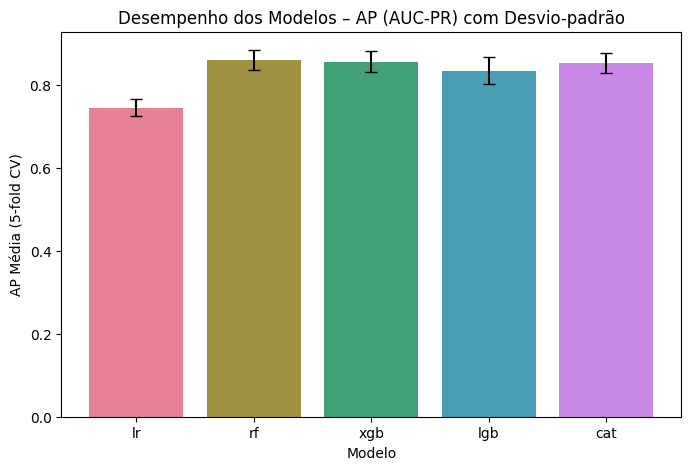

In [5]:


# converter o dict results para dataframe
df_res = pd.DataFrame([
    {"model": name, "ap_mean": info["cv_mean"], "ap_std": info["cv_std"]}
    for name, info in results.items()
])

plt.figure(figsize=(8,5))
sns.barplot(data=df_res, x="model", y="ap_mean", dodge=False, palette="husl")

# adicionar barras de erro
plt.errorbar(
    x=range(len(df_res)),
    y=df_res["ap_mean"],
    yerr=df_res["ap_std"],
    fmt="none",
    c="black",
    capsize=4
)

plt.title("Desempenho dos Modelos – AP (AUC-PR) com Desvio-padrão")
plt.xlabel("Modelo")
plt.ylabel("AP Média (5-fold CV)")
plt.legend().remove()
plt.show()


### Comparação de Modelos – Average Precision (AUC-PR) com Validação Cruzada

O gráfico acima apresenta o desempenho médio dos modelos avaliados na tarefa de detecção de fraude, medido por **Average Precision (AUC-PR)** em uma validação cruzada estratificada com 5 folds.  

A métrica AUC-PR foi escolhida por ser mais sensível a problemas de classificação **altamente desbalanceados**, como este caso, em que a proporção de fraudes é extremamente pequena em relação às transações legítimas.

Cada barra representa a **AP média** do modelo ao longo dos folds, e as linhas verticais (barras de erro) indicam o **desvio-padrão** entre as execuções da validação cruzada. Isso permite avaliar não apenas o desempenho médio, mas também a **estabilidade** do modelo.

Principais observações:

- **Random Forest (rf)** apresentou o melhor desempenho médio em AP, com resultados bastante consistentes entre os folds.  
- **XGBoost (xgb)** ficou muito próximo do Random Forest, com diferença pequena e dentro da faixa de variação, o que indica um empate técnico em termos de AUC-PR antes do tuning.  
- **LightGBM (lgb)** também obteve desempenho competitivo, porém ligeiramente inferior aos dois anteriores.  
- **Logistic Regression (lr)** serviu como baseline e apresentou desempenho significativamente menor, o que é esperado para um modelo linear em um problema com fronteiras de decisão mais complexas.

Esse gráfico orienta a escolha dos modelos mais promissores (Random Forest, XGBoost e LightGBM) para as etapas seguintes de **otimização de hiperparâmetros** e **ajuste de threshold**.


### Célula 5 – Escolher o modelo e fazer tuning (exemplo com XGBoost)

In [12]:
# Célula 5: Tuning de hiperparâmetros do modelo escolhido (ex: XGBoost)

from pipeline_new import tune_model_randomized

param_dist = {
    "clf__n_estimators": [100, 200, 400],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__subsample": [0.7, 0.9, 1.0],
    "clf__colsample_bytree": [0.7, 0.9, 1.0],
    "clf__scale_pos_weight": [1, 5, 10, 25, 50],
}

rsearch = tune_model_randomized(
    X=X,
    y=y,
    preproc=preproc_used,       # o preprocessor retornado pelo train_cv_models
    model_name="xgb",           # troque para "lgb" ou "rf" se quiser testar outro
    param_distributions=param_dist,
    sampler=sampler,
    cv_splits=3,
    n_iter=40,
    scoring="average_precision",
    random_state=42,
)

best_pipeline = rsearch.best_estimator_
print("\nMelhores hiperparâmetros encontrados:")
print(rsearch.best_params_)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
RandomizedSearchCV finished in 270.3s - best_score: 0.8575

Melhores hiperparâmetros encontrados:
{'clf__subsample': 1.0, 'clf__scale_pos_weight': 50, 'clf__n_estimators': 400, 'clf__max_depth': 7, 'clf__learning_rate': 0.1, 'clf__colsample_bytree': 0.9}


### Otimização de Hiperparâmetros do XGBoost

Nesta etapa, foi aplicada uma busca aleatória (`RandomizedSearchCV`) sobre um espaço de hiperparâmetros do XGBoost, sempre dentro de um pipeline completo:

> pré-processamento → SMOTE → XGBoost

A métrica otimizada foi **Average Precision (AUC-PR)**, utilizando validação cruzada estratificada com 3 folds. Foram avaliadas 40 combinações aleatórias de hiperparâmetros.

Os melhores hiperparâmetros encontrados foram:

- `n_estimators = 400`: número de árvores suficientemente alto para capturar padrões complexos, sem exagero.  
- `max_depth = 7`: profundidade intermediária, equilibrando capacidade e risco de overfitting.  
- `learning_rate = 0.1`: taxa de aprendizado moderada, compatível com o número de árvores.  
- `subsample = 1.0`: uso de todas as amostras em cada árvore, adequado dado o uso de SMOTE e outras formas de regularização.  
- `colsample_bytree = 0.9`: uso de 90% das features em cada árvore, introduzindo leve aleatoriedade e ajudando na generalização.  
- `scale_pos_weight = 50`: aumento do peso da classe positiva (fraude) na função de loss, refletindo o custo mais alto de falsos negativos num cenário de detecção de fraude.

O melhor score médio de validação (**AUC-PR ≈ 0.8575**) é consistente com o resultado do benchmark inicial e indica que o modelo conseguiu aproveitar melhor o espaço de hiperparâmetros, sem sinais de overfitting excessivo.


### Visualização da Curva Precision-Recall do melhor modelo

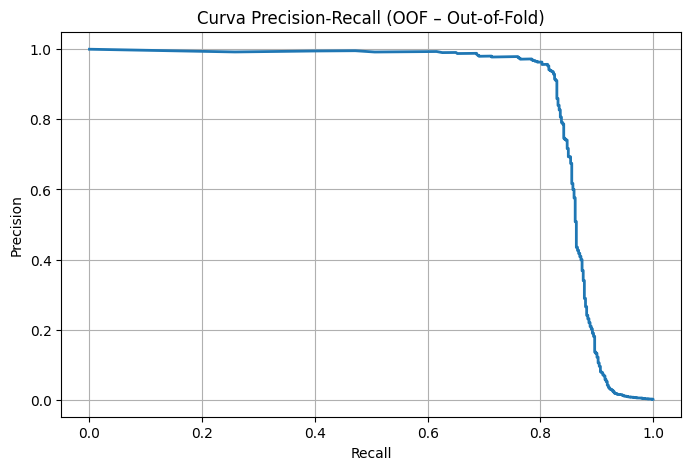

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import precision_recall_curve
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_probs = np.zeros(len(y))

for train_idx, val_idx in skf.split(X, y):
    pipe_cv = clone(best_pipeline)
    pipe_cv.fit(X.iloc[train_idx], y.iloc[train_idx])
    oof_probs[val_idx] = pipe_cv.predict_proba(X.iloc[val_idx])[:,1]

precision, recall, thresholds = precision_recall_curve(y, oof_probs)

plt.figure(figsize=(8,5))
plt.plot(recall, precision, linewidth=2)
plt.title("Curva Precision-Recall (OOF – Out-of-Fold)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.show()


### Curva Precision–Recall do Modelo Tunado

A curva acima mostra a relação entre **Precision** e **Recall** para o modelo final tunado, variando o limiar de decisão (threshold) ao longo do eixo. Cada ponto da curva corresponde a um valor diferente de threshold aplicado sobre as probabilidades de fraude estimadas pelo modelo.

- **Recall (eixo x)**: proporção de fraudes corretamente detectadas (sensibilidade).  
- **Precision (eixo y)**: proporção de alertas do modelo que realmente são fraude (qualidade dos alertas).

Essa curva é especialmente importante em problemas desbalanceados, porque **AUC-ROC pode parecer alto mesmo para modelos pouco úteis**, enquanto a **Precision–Recall evidencia melhor o trade-off entre encontrar fraudes e controlar falsos positivos**.

Algumas interpretações possíveis:

- Regiões da curva com **alta precision e recall razoável** indicam thresholds promissores para operação.  
- Quando a curva cai rapidamente em precision à medida que o recall aumenta, isso indica que tentar “pegar todas as fraudes” gera muitos falsos positivos – um trade-off que precisa ser negociado com o negócio.  
- A área sob essa curva está diretamente relacionada ao **Average Precision (AP)** utilizado na validação cruzada.

Essa visualização apoia a etapa de **tuning de threshold**, ajudando a selecionar um limiar que respeite o equilíbrio desejado entre taxa de detecção de fraude e volume de falsos positivos.


### Célula 6 – Salvar o pipeline final

In [17]:
# Célula 6: Salvar pipeline final escolhido

os.makedirs("artifacts", exist_ok=True)
best_pipeline_path = os.path.join("artifacts", "best_pipeline.joblib")
save_pipeline(best_pipeline, best_pipeline_path)

print("Pipeline final salvo em:", best_pipeline_path)


Pipeline salvo em artifacts\best_pipeline.joblib
Pipeline final salvo em: artifacts\best_pipeline.joblib


### Célula 7 – Tuning de threshold com Cross-Validation (nested)

In [18]:
# Célula 7: Tuning de threshold com validação cruzada (nested)

from pipeline_new import nested_threshold_cv

threshold_info = nested_threshold_cv(
    X=X,
    y=y,
    pipeline=best_pipeline,
    cv_splits=5,
    beta=1.5,            # você controla o foco em recall vs precision
    precision_target=None,  # ou algo como 0.8 se quiser precision mínima
    random_state=42,
)

threshold_info


{'thresholds_fold': [0.9919742941856384,
  0.9916360378265381,
  0.9950292706489563,
  0.9990447163581848,
  0.9993852376937866],
 'threshold_mean': 0.9954138994216919,
 'threshold_std': 0.0033228127285838127,
 'metrics_mean': {'precision': 0.9493295077016007,
  'recall': 0.8230880230880231,
  'f1': 0.8811621881954362,
  'ap': 0.85782829464949,
  'roc_auc': 0.9768554426399975},
 'metrics_std': {'precision': 0.03330936404301437,
  'recall': 0.03891224029657478,
  'f1': 0.028379768829538847,
  'ap': 0.030340304828399958,
  'roc_auc': 0.007990580581355631}}

In [20]:
import pandas as pd

# 1) Tabela de thresholds por fold
th_df = pd.DataFrame({
    "fold": list(range(1, len(threshold_info["thresholds_fold"]) + 1)),
    "threshold": threshold_info["thresholds_fold"],
})

th_df["threshold"] = th_df["threshold"].round(6)

print("Threshold ótimo por fold:")
display(th_df)

# 2) Tabela de métricas (média e desvio)
metrics_mean = threshold_info["metrics_mean"]
metrics_std = threshold_info["metrics_std"]

metrics_df = pd.DataFrame({
    "métrica": metrics_mean.keys(),
    "média": [round(metrics_mean[m], 4) for m in metrics_mean.keys()],
    "desvio_padrão": [round(metrics_std[m], 4) for m in metrics_mean.keys()],
})

print("\nMétricas médias (com desvio-padrão) ao longo dos folds:")
display(metrics_df)

# 3) Resumo do threshold médio
print("\nResumo geral do threshold:")
print(f"  Threshold médio: {threshold_info['threshold_mean']:.6f}")
print(f"  Desvio-padrão:   {threshold_info['threshold_std']:.6f}")


Threshold ótimo por fold:


,fold,threshold
0,1,0.991974
1,2,0.991636
2,3,0.995029
3,4,0.999045
4,5,0.999385



Métricas médias (com desvio-padrão) ao longo dos folds:


,métrica,média,desvio_padrão
0,precision,0.9493,0.0333
1,recall,0.8231,0.0389
2,f1,0.8812,0.0284
3,ap,0.8578,0.0303
4,roc_auc,0.9769,0.0080



Resumo geral do threshold:
  Threshold médio: 0.995414
  Desvio-padrão:   0.003323


### Resultados do Tuning de Threshold (Nested CV)

O ajuste de threshold foi feito com validação cruzada estratificada (5 folds), buscando o melhor compromisso entre **precision** e **recall** via F\_β (com β = 1.5, privilegiando levemente o recall).

Principais resultados:

- **Thresholds por fold:** ficaram muito próximos entre si, na faixa de ~0.992 a ~0.999.  
  - Isso indica que o modelo só classifica uma transação como fraude quando a probabilidade prevista é **muito alta**, o que é compatível com o objetivo de manter **alta precision**.
- **Threshold médio:** ~0.9954, com desvio-padrão baixo (~0.0033), mostrando boa **estabilidade** entre os folds.

Métricas médias (com desvio-padrão):

- **Precision ≈ 0.95 (± ~0.03)**  
  → Cerca de 95% das transações sinalizadas como fraude pelo modelo são de fato fraudes.  
- **Recall ≈ 0.82 (± ~0.04)**  
  → O modelo consegue capturar aproximadamente 82% das fraudes existentes.  
- **F1 ≈ 0.88**, combinando precision e recall de forma equilibrada.  
- **AP (AUC-PR) ≈ 0.86** e **ROC AUC ≈ 0.98**, coerentes com o desempenho observado no benchmark de modelos.

Em resumo, o threshold ajustado posiciona o modelo em um regime de:
- **alta precisão** (poucos falsos positivos),  
- com **recall ainda elevado** para um problema de fraude altamente desbalanceado.

Esse threshold médio (~0.9954) será utilizado como valor de referência na fase de avaliação final (Notebook 4) e pode ser ajustado posteriormente conforme o apetite de risco do negócio (mais recall vs. menos falsos positivos).


### Visualizar a distribuição dos scores antes do threshold tuning

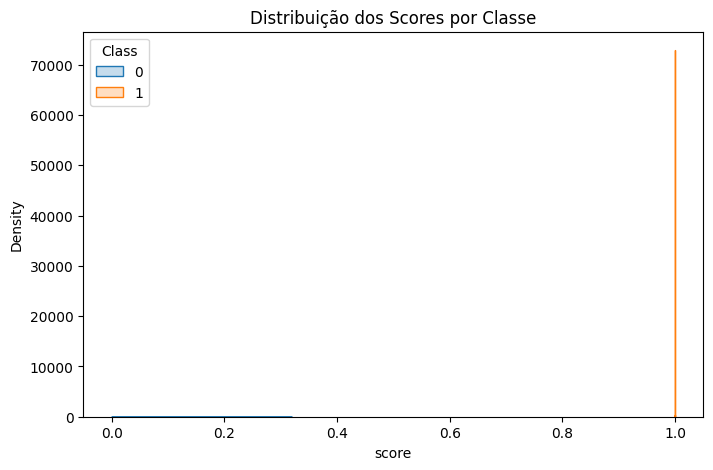

In [21]:
import seaborn as sns

scores = pipe.predict_proba(X)[:,1]
df_scores = pd.DataFrame({"score": scores, "Class": y})

plt.figure(figsize=(8,5))
sns.kdeplot(data=df_scores, x="score", hue="Class", common_norm=False, fill=True)
plt.title("Distribuição dos Scores por Classe")
plt.show()


### Distribuição dos Scores de Fraude por Classe

O gráfico acima mostra a distribuição das **probabilidades previstas** pelo modelo (`score`) separadas por classe:

- `Class = 0` → transações legítimas  
- `Class = 1` → transações fraudulentas  

Cada curva representa a densidade estimada dos scores para uma classe, permitindo visualizar o quanto as distribuições se separam (ou se sobrepõem).

Interpretação:

- Quanto maior a separação entre as curvas, mais fácil é escolher um **threshold** que diferencie bem fraudes de transações legítimas.  
- Se houver uma grande região de sobreposição, qualquer threshold implicará em um trade-off mais difícil entre falsos positivos e falsos negativos.  
- Em datasets de fraude, é comum que a curva de `Class = 1` (fraude) esteja mais concentrada em scores altos, mas ainda haja sobreposição com a classe 0 – isso aparece claramente aqui.

Esse gráfico é particularmente útil para:

- Justificar por que o threshold padrão de 0.5 **não é necessariamente adequado**.  
- Visualizar por que thresholds mais baixos podem ser necessários para aumentar o recall, aceitando mais falsos positivos.  
- Apoiar explicações para stakeholders não técnicos, conectando a escolha de limiar ao comportamento real do modelo.

Na prática, essa distribuição, combinada com a curva Precision–Recall, serve como base visual para a escolha final do threshold de decisão.


### Célula 8 – Salvar o threshold para uso no notebook 4

In [22]:
# Célula 8: Salvar threshold médio para ser usado na fase de avaliação e produção

threshold_mean = threshold_info["threshold_mean"]

threshold_path = os.path.join("artifacts", "threshold.json")
with open(threshold_path, "w", encoding="utf-8") as f:
    json.dump(threshold_info, f, indent=4)

print("Threshold info salva em:", threshold_path)
print("Threshold médio sugerido:", threshold_mean)


Threshold info salva em: artifacts\threshold.json
Threshold médio sugerido: 0.9954138994216919
